In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [ ]:
# # Read coverage file for each population at each timepoint

# filepath = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Community mutants\\'
# folders = ['PopA', 'PopB', 'PopC', 'PopD', 'PopE', 'PopF', 'PopG', 'PopH']

# # Coverage_popA
# fp = filepath + folders[7] + '\\'
# df = pd.read_csv(fp + 'Coverage0.csv')

# for ind, file in enumerate(glob.glob(fp + 'CoverageH*.csv')):
#     df_ = pd.read_csv(file)
#     df = df.merge(df_, on = ['Position'], how = 'outer')
# # df.columns = ['Position', 'A0', 'A1', 'A2', 'A3', 'A4', 'A7', 'A8'] 
# # df.columns = ['Position', 'B0', 'B1', 'B2', 'B3', 'B4', 'B6','B7', 'B8'] 
# # df.columns = ['Position', 'C0', 'C1', 'C2', 'C3', 'C4', 'C6','C7', 'C8'] 
# # df.columns = ['Position', 'D0', 'D1', 'D2', 'D3', 'D4', 'D6','D7', 'D8']
# # df.columns = ['Position', 'E0', 'E1', 'E2', 'E3', 'E4', 'E6','E7', 'E8']
# # df.columns = ['Position', 'F0', 'F1', 'F2', 'F3', 'F4', 'F6','F7', 'F8']
# # df.columns = ['Position', 'G0', 'G1', 'G2', 'G3', 'G4', 'G6','G7', 'G8']
# df.columns = ['Position', 'H0', 'H1', 'H2', 'H3', 'H4', 'H6','H7', 'H8']
# print(len(df))
# df.head(5)

In [ ]:
## Run the blocks of functions first, and then walk through the scripts of section 1-8. 
## The related analysis of common variance shared by population A-H and timepoints 1-8 
## is in section 8.We missed timepoint 5 for all populations and missed timepoint 6 for the popA.

In [20]:
def import_vcfs(file_path, folders, select_col_names):
    '''
    Inputs:
    file_path = the main path where all files saved
    folders = names of folders where variance files were saved by populations
    select_col_names = names of selected columns from the original data 
    
    Outputs:
    VCFs = dictionary of lists. Keys of dictionary are the population labels and each key directs to the dataframe list across timepoints
    Pop_gens = dictionary of lists. Keys of dictionary are the population labels and each key directs to the list of generation name
    '''
    VCFs = dict()
    Pop_Gens = dict()
    for fd in folders:
        VCFs[fd] = list()
        Pop_Gens[fd] = list()
        for file in glob.glob(file_path + fd + "\\CMT*.csv"):
#             print(file)
            gen = file.split("CM")[1][1:3]
#             gen = file.split("CM")[3][1:3]
            Pop_Gens[fd].append(gen)               
            vcf = pd.read_csv(file, low_memory=False)
            vcf = vcf.loc[vcf['Average Quality'] > 25]
            vcf = vcf[select_col_names]
            vcf[gen + ' VF'] = vcf['Variant Frequency'].apply(lambda x: float(x.split('%')[0])/100)
            vcf = vcf.drop('Variant Frequency', axis =1)
            vcf[gen + ' Coverage'] = vcf['Coverage'].apply(lambda x: int(x.split('->')[0]))       
            vcf = vcf.drop('Coverage', axis =1)
            vcf = vcf.loc[vcf[gen + ' Coverage'] > 10] 
#             vcf['Minimum'].astype(int)
#             vcf['Maximum'].astype(int)
            VCFs[fd].append(vcf)

    return VCFs, Pop_Gens

In [4]:
def merge_vcfs(VCFs, pop_lab):
    '''
    Inputs:
    VCFs = imported variance files of all populations across all time points by import_vcfs()
    pop_labels = population label (e.g. 'A')
    
    Outputs:
    vcf_cmt = the merged vcfs across timepoints for the indicated population
    '''
    col_names = ['Name', 'Minimum', 'Maximum','Sequence','locus_tag', 'Protein Effect', 'note']
    vcfs = VCFs[pop_lab]
    vcf_cmt = vcfs[1]
    for df in vcfs[2:]:
        vcf_cmt = vcf_cmt.merge(df, on= col_names, how = 'outer')
#     col_VF = vcf_cmt.columns[7::2]
#     col_cov = vcf_cmt.columns[8::2]
#     vcf_cmt[col_VF] = vcf_cmt[col_VF].fillna(0)
#     vcf_cmt[col_cov] = vcf_cmt[col_cov].fillna(0)
#     vcf_cmt = vcf_cmt.drop(col_cov,axis = 1)
    vcf_cmt['locus_tag'] = vcf_cmt['locus_tag'].fillna('Intergenetic region')
#     mask_str1 = vcf_cmt['Minimum'].apply(lambda x: isinstance(x, str))
#     vcf_cmt.loc[mask_str1, 'Minimum'] = vcf_cmt.loc[mask_str1,'Minimum'].astype(int)

#     mask_str2 = vcf_cmt['Maximum'].apply(lambda x: isinstance(x, str))
#     vcf_cmt.loc[mask_str2, 'Maximum'] = vcf_cmt.loc[mask_str2,'Maximum'].astype(int)
    return vcf_cmt

In [5]:
def location_reverse(rep_vcfs):
    # Some genes are reversely transcribed from 3' to 5' on the chromosome. Variances found in these genes
    # have the "Minimum" location > "Maximum" location. For the consistency of the following analysis, the 
    # "Minimum" and "Maximum" values of these variances are reversed. 
    '''
    Inputs:
    rep_vcfs =  the merged vcfs across timepoints for the indicated population generated by merge_vcfs_by_repeats()
    
    Outputs:
    rep_vcfs that have the "Minimum", "Maximum" corrected
    '''
    vcf_reverse = rep_vcfs[["Minimum", "Maximum"]]. where(rep_vcfs["Minimum"] > rep_vcfs["Maximum"]).dropna()
    row_ind = vcf_reverse.index
    rep_vcfs.loc[row_ind, "Minimum"] = vcf_reverse["Maximum"]
    rep_vcfs.loc[row_ind, "Maximum"] = vcf_reverse["Minimum"]
    #vcf.drop("index", axis = 1)
    #vcf = vcf.set_index(['Minimum','Maximum', 'Name'])
    return rep_vcfs

In [21]:
path = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\'
# path = 'E:\\CMT_project\\CMT project\\'
genomic_table_coelicolor = pd.read_csv(path + 'genomic_table_coelicolor.csv')
path = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\Genomics\\Community mutants\\antiSMASH_Streptomyces_coelicolor\\'
# path = 'E:\\CMT_project\\CMT project\\'
filename = 'index.html'
cluster_info = pd.read_html(path+filename)[0].drop(0)

In [22]:
## Change the pathway where your vcfs are saved
# file_path = 'E:\\CMT_project\\CMT project\\' 
file_path = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\Genomics\\Community mutants\\'
# file_path = 'E:\\CMT_project\\CMT project\\'
folders = ['PopA', 'PopB', 'PopC', 'PopD', 'PopE', 'PopF', 'PopG', 'PopH']
select_col_names = ['Name', 'Minimum', 'Maximum','Sequence','locus_tag', 
                    'Protein Effect',  'note', 'Variant Frequency', 'Coverage']
# Quick look at what files in these folders
# for fd in folders:
#     for file in glob.glob(file_path + fd + "\\CMT*.csv"):
#         print(file)

In [23]:
## Data Minining using the above functions##
# 1. Import all files and organize by population labels "A", "B", "C", etc
VCFs, Pop_gens = import_vcfs(file_path, folders, select_col_names)

In [24]:
VCFs['PopD'][1].head(3)
num_var = dict()
for pop in folders:
    num_var[pop] = list(map(lambda x:len(VCFs[pop][x]), range(len(VCFs[pop]))))
    
num_var
# Pop_gens['PopB']

{'PopA': [104, 119, 93, 83, 123, 124, 126],
 'PopB': [104, 141, 101, 121, 144, 124, 160, 221706],
 'PopC': [104, 118, 113, 120, 154, 155, 126, 138],
 'PopD': [104, 137, 100, 117, 152, 147, 145, 281],
 'PopE': [104, 147, 99, 118, 142, 140, 124, 228609],
 'PopF': [104, 151, 107, 121, 150, 124, 128, 217699],
 'PopG': [104, 144, 101, 102, 150, 138, 113, 167487],
 'PopH': [104, 152, 97, 94, 126, 139, 137, 221706]}

In [30]:
# 2. Reorganize the VCFs and merge vcfs across timepoints for each repeat (e.g.merge T1, T2 to T8 for population A)
vcfs_A = merge_vcfs(VCFs, 'PopA')
vcfs_B = merge_vcfs(VCFs, 'PopB')
vcfs_C = merge_vcfs(VCFs, 'PopC')
vcfs_D = merge_vcfs(VCFs, 'PopD')
vcfs_E = merge_vcfs(VCFs, 'PopE')
vcfs_F = merge_vcfs(VCFs, 'PopF')
vcfs_G = merge_vcfs(VCFs, 'PopG')
vcfs_H = merge_vcfs(VCFs, 'PopH')

In [31]:
# Check the size of variance of each population
print(len(vcfs_A), len(vcfs_B), len(vcfs_C), len(vcfs_D), len(vcfs_E), len(vcfs_F), len(vcfs_G), len(vcfs_H))

mask_str = vcfs_D['Minimum'] == '<8267251'
vcfs_D.loc[mask_str, 'Minimum'] = int(8267248)

mask_str1 = vcfs_D['Minimum'].apply(lambda x: isinstance(x, str))
vcfs_D.loc[mask_str1, 'Minimum'] = vcfs_D.loc[mask_str1,'Minimum'].astype(int)
mask_str2 = vcfs_D['Maximum'].apply(lambda x: isinstance(x, str))
vcfs_D.loc[mask_str2, 'Maximum'] = vcfs_D.loc[mask_str2,'Maximum'].astype(int)

220 221976 305 569 228854 217912 167635 221976


In [32]:
colnames = vcfs_D.columns
colnames[7::2][0:-1]

Index(['1D VF', '2D VF', '3D VF', '4D VF', '6D VF', '7D VF'], dtype='object')

Text(0,0.5,'number of variances')

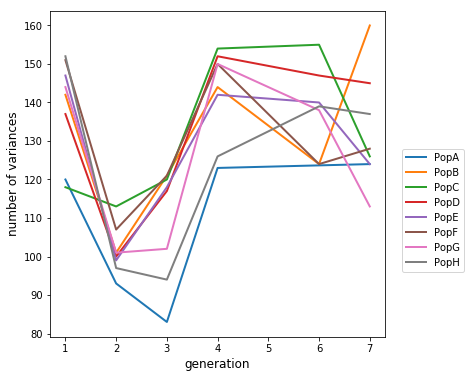

In [33]:
plt.figure(figsize = [6,6])
for i, vcf in enumerate([vcfs_A, vcfs_B, vcfs_C, vcfs_D, vcfs_E, vcfs_F, vcfs_G, vcfs_H]):
    col_names = vcf.columns
    col_vf_names = col_names[7::2][0:-1]
    num_var_t = np.sum(vcf[col_vf_names] > 0)
    gen = [int(x) for x in num_var_t.index.str[0]]
    plt.plot(gen, num_var_t, lw = 2)
    
plt.legend(folders, loc = [1.05, 0.2])
plt.xlabel('generation', size = 12)
plt.ylabel('number of variances', size = 12)

In [34]:
# 3. Correct the "Minimum", "Maximum" of variances that are located in reverse transcribed genes
# Before correction:
num_reverseA1 = str(np.sum(vcfs_A["Minimum"] > vcfs_A["Maximum"]))
num_reverseB1 = str(np.sum(vcfs_B["Minimum"] > vcfs_B["Maximum"]))
num_reverseC1 = str(np.sum(vcfs_C["Minimum"] > vcfs_C["Maximum"]))
num_reverseD1 = str(np.sum(vcfs_D["Minimum"] > vcfs_D["Maximum"]))
num_reverseE1 = str(np.sum(vcfs_E["Minimum"] > vcfs_E["Maximum"]))
num_reverseF1 = str(np.sum(vcfs_F["Minimum"] > vcfs_F["Maximum"]))
num_reverseG1 = str(np.sum(vcfs_G["Minimum"] > vcfs_G["Maximum"]))
num_reverseH1 = str(np.sum(vcfs_H["Minimum"] > vcfs_H["Maximum"]))

print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseA1, "vcfs_A"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseB1, "vcfs_B"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseC1, "vcfs_C"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseD1, "vcfs_D"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseE1, "vcfs_E"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseF1, "vcfs_F"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseG1, "vcfs_G"))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverseH1, "vcfs_H"))


vcfs_A_ = location_reverse(vcfs_A)
vcfs_B_ = location_reverse(vcfs_B)
vcfs_C_ = location_reverse(vcfs_C)
vcfs_D_ = location_reverse(vcfs_D)
vcfs_E_ = location_reverse(vcfs_E)
vcfs_F_ = location_reverse(vcfs_F)
vcfs_G_ = location_reverse(vcfs_G)
vcfs_H_ = location_reverse(vcfs_H)
# # Check if it worked right

num_reverseA2 = str(np.sum(vcfs_A_["Minimum"] > vcfs_A_["Maximum"]))
num_reverseB2 = str(np.sum(vcfs_B_["Minimum"] > vcfs_B_["Maximum"]))
num_reverseC2 = str(np.sum(vcfs_C_["Minimum"] > vcfs_C_["Maximum"]))
num_reverseD2 = str(np.sum(vcfs_D_["Minimum"] > vcfs_D_["Maximum"]))
num_reverseE2 = str(np.sum(vcfs_E_["Minimum"] > vcfs_E_["Maximum"]))
num_reverseF2 = str(np.sum(vcfs_F_["Minimum"] > vcfs_F_["Maximum"]))
num_reverseG2 = str(np.sum(vcfs_G_["Minimum"] > vcfs_G_["Maximum"]))
num_reverseH2 = str(np.sum(vcfs_H_["Minimum"] > vcfs_H_["Maximum"]))

print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseA2, "vcfs_A"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseB2, "vcfs_B"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseC2, "vcfs_C"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseD2, "vcfs_D"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseE2, "vcfs_E"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseF2, "vcfs_F"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseG2, "vcfs_G"))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverseH2, "vcfs_H"))

Before correction, there are 55 reversed SNPs locations in vcfs_A
Before correction, there are 1239 reversed SNPs locations in vcfs_B
Before correction, there are 84 reversed SNPs locations in vcfs_C
Before correction, there are 107 reversed SNPs locations in vcfs_D
Before correction, there are 1265 reversed SNPs locations in vcfs_E
Before correction, there are 779 reversed SNPs locations in vcfs_F
Before correction, there are 454 reversed SNPs locations in vcfs_G
Before correction, there are 1218 reversed SNPs locations in vcfs_H
After correction, there are 0 reversed SNPs locations in vcfs_A
After correction, there are 0 reversed SNPs locations in vcfs_B
After correction, there are 0 reversed SNPs locations in vcfs_C
After correction, there are 0 reversed SNPs locations in vcfs_D
After correction, there are 0 reversed SNPs locations in vcfs_E
After correction, there are 0 reversed SNPs locations in vcfs_F
After correction, there are 0 reversed SNPs locations in vcfs_G
After correctio

In [36]:
# Save the corected and merged vcfs for each population
savepath = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Community mutants\\'
savefolders = ['PopA', 'PopB', 'PopC', 'PopD', 'PopE', 'PopF', 'PopG', 'PopH']
vcfs_A.to_csv(savepath + savefolders[0] + '\\vcfs_A.csv')
vcfs_B.to_csv(savepath + savefolders[1] + '\\vcfs_B.csv')
vcfs_C.to_csv(savepath + savefolders[2] + '\\vcfs_C.csv')
vcfs_D.to_csv(savepath + savefolders[3] + '\\vcfs_D.csv')
vcfs_E.to_csv(savepath + savefolders[4] + '\\vcfs_E.csv')
vcfs_F.to_csv(savepath + savefolders[5] + '\\vcfs_F.csv')
vcfs_G.to_csv(savepath + savefolders[6] + '\\vcfs_G.csv')
vcfs_H.to_csv(savepath + savefolders[7] + '\\vcfs_H.csv')